**CSCI316 Group Assignment Task 2**
---
Name: Ryan Hong Yang Tan

Student No.: 8560341

---
Name: Sim Zhan Qi

Student No.: 8930831

---
Name: Au Wei Xiang

Student No.: 7538753

---
Name: Pek Xin Ying Janice

Student No.: 7579172



---


Name: Trustan Wu

Student No.: 7558867

In [ ]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, count, when
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark Session
spark = SparkSession.builder.appName("FlightPricePreprocessing").getOrCreate()

# Load Data
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")

flightPathDF = spark.read.csv(f"{path}/Clean_Dataset.csv", header=True, inferSchema=True)

In [ ]:
flightPathDF.show()

+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|_c0|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  0| SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|  1| SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  2|  AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  3|  Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  4|  Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
|  5|  Vistara| UK-945|      Del

In [ ]:
flightPathDF.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flight: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)



In [ ]:
# Count nulls in each column
null_counts = flightPathDF.agg(*[
  count(when(col(c).isNull(), c)).alias(c) for c in flightPathDF.columns
])
null_counts.show()

+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|_c0|airline|flight|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|price|
+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|  0|      0|     0|          0|             0|    0|           0|               0|    0|       0|        0|    0|
+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+



In [ ]:
# Drop Unnecessary Columns
flightPathDF = flightPathDF.drop(flightPathDF.columns[0]).drop(flightPathDF.columns[2])
flightPathDF.show()

+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
| SpiceJet|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
| SpiceJet|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  AirAsia|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  Vistara|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  Vistara|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
|  Vistara|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.33|        1| 5955|
|  Vistara|      De

In [ ]:
# Define UDFs for Column Mappings
def class_mapping(val):
  return 0 if val == "Economy" else 1

def stops_mapping(val):
  return 0 if val == "zero" else 1 if val == "one" else 2

def time_mapping(val):
  time_dict = {"Early_Morning": 0, "Morning": 1, "Afternoon": 2, "Evening": 3, "Night": 4}
  return time_dict.get(val, 5)

def booking_urgency_mapping(val):
  return 2 if val < 7 else 1 if val < 30 else 0

# Register UDFs
class_udf = udf(class_mapping, IntegerType())
stops_udf = udf(stops_mapping, IntegerType())
time_udf = udf(time_mapping, IntegerType())
urgency_udf = udf(booking_urgency_mapping, IntegerType())

# Apply Transformations
flightPathDF = (flightPathDF
              .withColumn("class", class_udf(col("class")))
              .withColumn("stops", stops_udf(col("stops")))
              .withColumn("departure_time", time_udf(col("departure_time")))
              .withColumn("arrival_time", time_udf(col("arrival_time")))
              .withColumn("booking_urgency", urgency_udf(col("days_left")))
)

In [ ]:
flightPathDF.show()

+---------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+---------------+
|  airline|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|price|booking_urgency|
+---------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+---------------+
| SpiceJet|      Delhi|             3|    0|           4|          Mumbai|    0|    2.17|        1| 5953|              2|
| SpiceJet|      Delhi|             0|    0|           1|          Mumbai|    0|    2.33|        1| 5953|              2|
|  AirAsia|      Delhi|             0|    0|           0|          Mumbai|    0|    2.17|        1| 5956|              2|
|  Vistara|      Delhi|             1|    0|           2|          Mumbai|    0|    2.25|        1| 5955|              2|
|  Vistara|      Delhi|             1|    0|           1|          Mumbai|    0|    2.33|        1| 5955|              2|
|  Vistara|      Delhi| 

In [ ]:
# Define String Indexers for Categorical Columns
airline_indexer = StringIndexer(inputCol="airline", outputCol="airline_index")
source_city_indexer = StringIndexer(inputCol="source_city", outputCol="source_city_index")
destination_city_indexer = StringIndexer(inputCol="destination_city", outputCol="destination_city_index")

# Define One-Hot Encoders
airline_encoder = OneHotEncoder(inputCol="airline_index", outputCol="airlineOHE")
source_city_encoder = OneHotEncoder(inputCol="source_city_index", outputCol="source_cityOHE")
destination_city_encoder = OneHotEncoder(inputCol="destination_city_index", outputCol="destination_cityOHE")

In [ ]:
flightPathDF.printSchema()
flightPathDF.show()

root
 |-- airline: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: integer (nullable = true)
 |-- stops: integer (nullable = true)
 |-- arrival_time: integer (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: integer (nullable = true)
 |-- duration: double (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- booking_urgency: integer (nullable = true)

+---------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+---------------+
|  airline|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|price|booking_urgency|
+---------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+---------------+
| SpiceJet|      Delhi|             3|    0|           4|          Mumbai|    0|    2.17|        1| 5953|              2|
| SpiceJet|      Delhi|             0|  

In [ ]:
# Assemble Features
assembler = VectorAssembler(
  inputCols=[
    "class", "stops", "departure_time", "arrival_time", "booking_urgency",
    "airlineOHE", "source_cityOHE", "destination_cityOHE"
  ],
  outputCol="features"
)

# Define Pipeline
pipeline = Pipeline(stages=[
  airline_indexer, source_city_indexer, destination_city_indexer,
  airline_encoder, source_city_encoder, destination_city_encoder,
  assembler
])

# Transform Data
flightPathDF_transformed = pipeline.fit(flightPathDF).transform(flightPathDF)

# Select Final Columns
flightPathDF_final = flightPathDF_transformed.select("features", col("price").alias("label"))

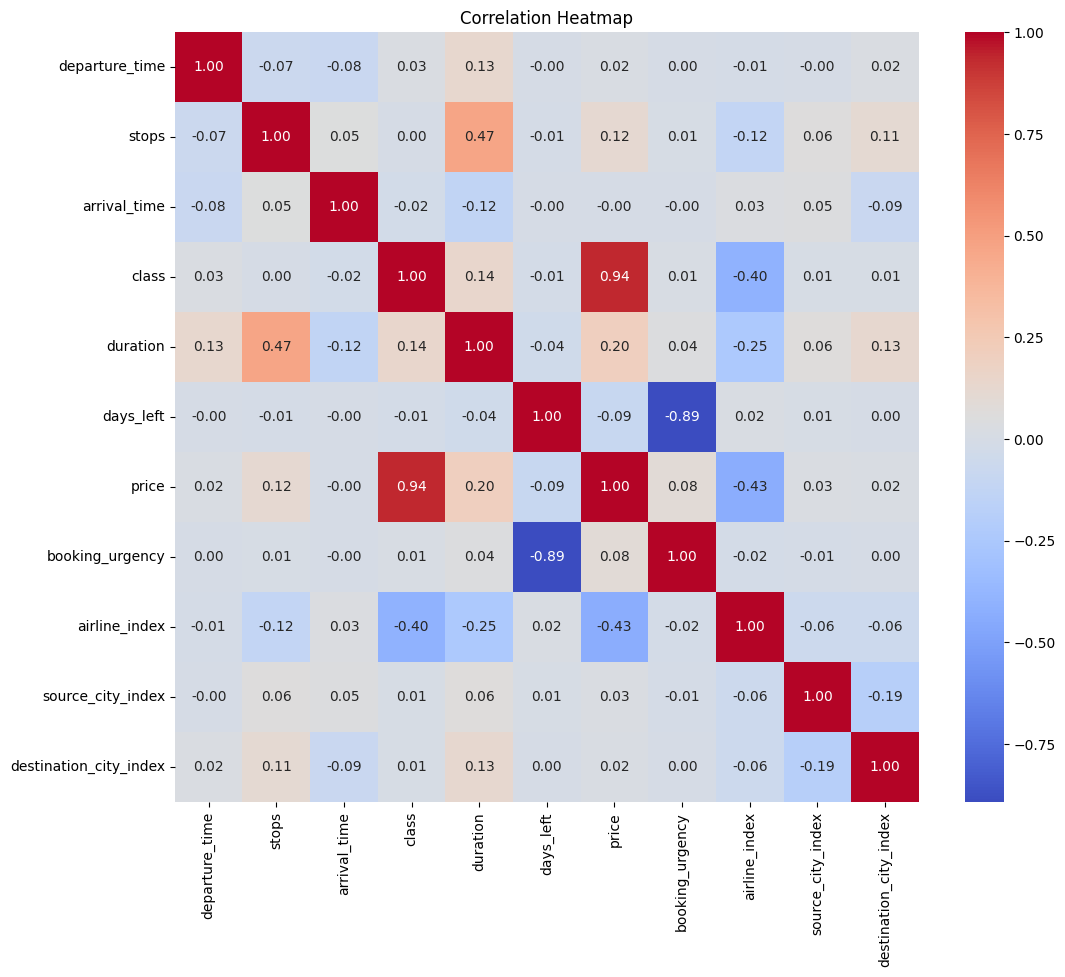

In [ ]:
# Convert to pandas DataFrame for correlation, including all columns
flightPathDF_pandas = flightPathDF_transformed.select(
  "*"
).toPandas()

# Select only numeric columns for correlation calculation
numeric_columns = flightPathDF_pandas.select_dtypes(include=[np.number]).columns
flightPathDF_numeric = flightPathDF_pandas[numeric_columns]

# Calculate the correlation matrix
corr_matrix = flightPathDF_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# Split Data into Train & Test Sets
train_data, test_data = flightPathDF_final.randomSplit([0.8, 0.2], seed=42)

# Show Data
print(f"Train size: {train_data.count()}, Test size: {test_data.count()}")
train_data.show(5)

Train size: 240168, Test size: 59985
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(20,[1,2,3,4,5,10...|11625|
|(20,[1,2,3,4,5,10...|11520|
|(20,[1,2,3,4,5,10...|11625|
|(20,[1,2,3,4,5,10...|13095|
|(20,[1,2,3,4,5,10...|13095|
+--------------------+-----+
only showing top 5 rows



Decision Tree
---

---


In [ ]:
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label")

# Hyperparameter Tuning
paramGrid_dt = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [20, 25, 30])\
    .build()

crossval_dt = CrossValidator(estimator=dt,
                             estimatorParamMaps=paramGrid_dt,
                             evaluator=RegressionEvaluator(labelCol='label', metricName="mse"),
                             numFolds=3)

# Train Model
cv_model_dt = crossval_dt.fit(train_data)
best_model_dt = cv_model_dt.bestModel

In [ ]:
evaluator_dt = RegressionEvaluator(labelCol="label", metricName="mse")

# Training performance
y_train_prediction_dt = best_model_dt.transform(train_data)
mse_train_dt = evaluator_dt.evaluate(y_train_prediction_dt)
rmse_train_dt = np.sqrt(mse_train_dt)
mae_train_dt = RegressionEvaluator(labelCol="label", metricName="mae").evaluate(y_train_prediction_dt)
r2_train_dt = RegressionEvaluator(labelCol="label", metricName="r2").evaluate(y_train_prediction_dt)

# Evaluate Model
y_predictions_dt = best_model_dt.transform(test_data)
mse_test_dt = evaluator_dt.evaluate(y_predictions_dt)
rmse_test_dt = np.sqrt(mse_test_dt)
mae_test_dt = RegressionEvaluator(labelCol="label", metricName="mae").evaluate(y_predictions_dt)
r2_test_dt = RegressionEvaluator(labelCol="label", metricName="r2").evaluate(y_predictions_dt)

# Print Results
print(f"Best Model Depth: {best_model_dt.getMaxDepth()}")
# Print training and test performance metrics
print(f'---Decision Tree Model Performance---')
print(f"Train MSE: {mse_train_dt}, Test MSE: {mse_test_dt}")
print(f"Train RMSE: {rmse_train_dt}, Test RMSE: {rmse_test_dt}")
print(f"Train MAE: {mae_train_dt}, Test MAE: {mae_test_dt}")
print(f"Train R-Squared: {r2_train_dt}, Test R-Squared: {r2_test_dt}")

Best Model Depth: 30
---Decision Tree Model Performance---
Train MSE: 15925864.637927884, Test MSE: 17432124.37476036
Train RMSE: 3990.722320323463, Test RMSE: 4175.179561978186
Train MAE: 2323.786973814836, Test MAE: 2441.642960569718
Train R-Squared: 0.9691219129712002, Test R-Squared: 0.9660100980086185


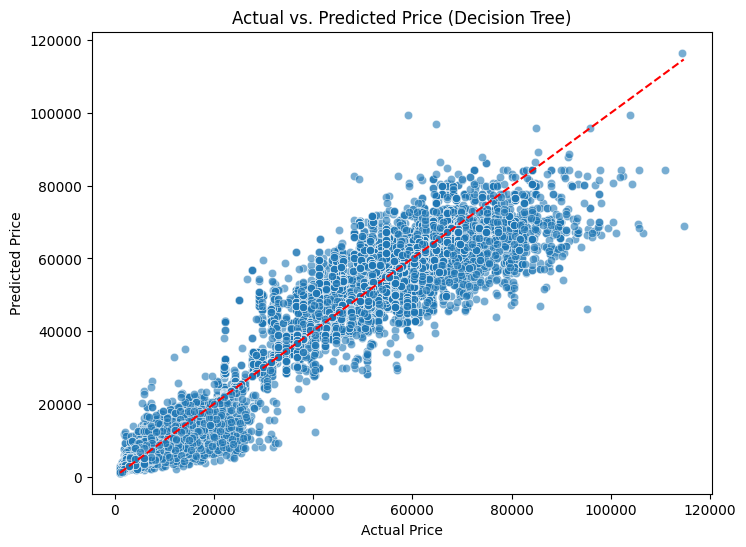

In [ ]:
y_predictions_pd_dt = y_predictions_dt.select("label", "prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_predictions_pd_dt['label'], y=y_predictions_pd_dt['prediction'], alpha=0.6)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price (Decision Tree)")
plt.plot([min(y_predictions_pd_dt['label']), max(y_predictions_pd_dt['label'])], [min(y_predictions_pd_dt['label']), max(y_predictions_pd_dt['label'])], color='red', linestyle='--')  # Add a diagonal line
plt.show()

Random Forest Regressor
---

---

In [ ]:
#initialise and train model
rf = RandomForestRegressor(featuresCol="features", labelCol="label")

# Hyperparameter Tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid,
                             evaluator=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse"),
                             numFolds=5, parallelism=2)

# Train Model
cv_model_rf = crossval_rf.fit(train_data)
best_model_rf = cv_model_rf.bestModel

In [ ]:
evaluator_rf = RegressionEvaluator(labelCol="label", metricName="mse")

# Training performance
y_train_prediction_rf = best_model_rf.transform(train_data)
mse_train_rf = evaluator_rf.evaluate(y_train_prediction_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
mae_train_rf = RegressionEvaluator(labelCol="label", metricName="mae").evaluate(y_train_prediction_rf)
r2_train_rf = RegressionEvaluator(labelCol="label", metricName="r2").evaluate(y_train_prediction_rf)

# Evaluate Model
y_predictions_rf = best_model_rf.transform(test_data)
mse_test_rf = evaluator_rf.evaluate(y_predictions_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
mae_test_rf = RegressionEvaluator(labelCol="label", metricName="mae").evaluate(y_predictions_rf)
r2_test_rf = RegressionEvaluator(labelCol="label", metricName="r2").evaluate(y_predictions_rf)

# Print Results
print(f"Best Model Depth: {best_model_rf.getMaxDepth()}")
# Print training and test performance metrics
print(f'---Random Forest Model Performance---')
print(f"Train MSE: {mse_train_rf}, Test MSE: {mse_test_rf}")
print(f"Train RMSE: {rmse_train_rf}, Test RMSE: {rmse_test_rf}")
print(f"Train MAE: {mae_train_rf}, Test MAE: {mae_test_rf}")
print(f"Train R-Squared: {r2_train_rf}, Test R-Squared: {r2_test_rf}")

Best Model Depth: 15
---Random Forest Model Performance---
Train MSE: 19851427.091488067, Test MSE: 19958283.961072832
Train RMSE: 4455.494034502579, Test RMSE: 4467.469525477799
Train MAE: 2716.019436809334, Test MAE: 2735.7822784977093
Train R-Squared: 0.9615107809018402, Test R-Squared: 0.9610844839579483


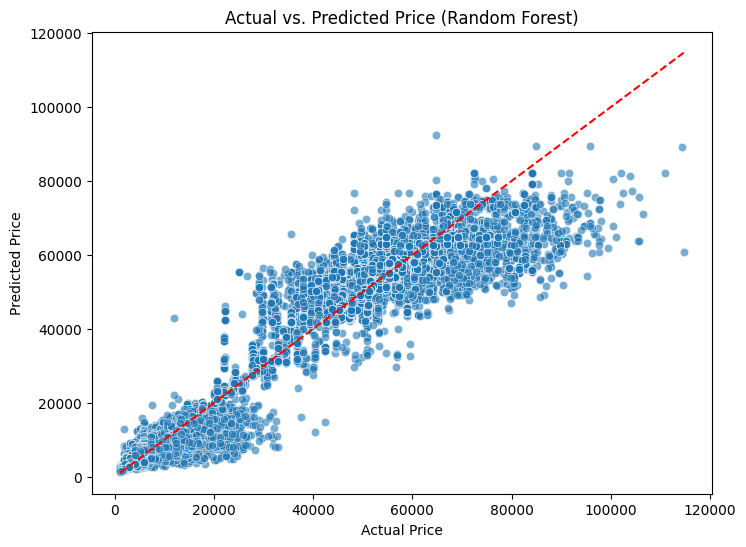

In [ ]:
y_predictions_pd_rf = y_predictions_rf.select("label", "prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_predictions_pd_rf['label'], y=y_predictions_pd_rf['prediction'], alpha=0.6)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price (Random Forest)")
plt.plot([min(y_predictions_pd_rf['label']), max(y_predictions_pd_rf['label'])], [min(y_predictions_pd_rf['label']), max(y_predictions_pd_rf['label'])], color='red', linestyle='--')  # Add a diagonal line
plt.show()

Gradient Boosted Tree
---
---



In [ ]:
# Define Gradient Boosted Trees Regressor
gbt = GBTRegressor(featuresCol="features", labelCol="label")

# Hyperparameter Tuning
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 10, 15])\
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=RegressionEvaluator(labelCol='label', metricName="mse"),
                              numFolds=5)

# Train Model
cv_model_gbt = crossval_gbt.fit(train_data)
best_model_gbt = cv_model_gbt.bestModel

In [ ]:
evaluator_gbt = RegressionEvaluator(labelCol="label", metricName="mse")

# Training pegbtormance
y_train_prediction_gbt = best_model_gbt.transform(train_data)
mse_train_gbt = evaluator_gbt.evaluate(y_train_prediction_gbt)
rmse_train_gbt = np.sqrt(mse_train_gbt)
mae_train_gbt = RegressionEvaluator(labelCol="label", metricName="mae").evaluate(y_train_prediction_gbt)
r2_train_gbt = RegressionEvaluator(labelCol="label", metricName="r2").evaluate(y_train_prediction_gbt)

# Evaluate Model
y_predictions_gbt = best_model_gbt.transform(test_data)
mse_test_gbt = evaluator_gbt.evaluate(y_predictions_gbt)
rmse_test_gbt = np.sqrt(mse_test_gbt)
mae_test_gbt = RegressionEvaluator(labelCol="label", metricName="mae").evaluate(y_predictions_gbt)
r2_test_gbt = RegressionEvaluator(labelCol="label", metricName="r2").evaluate(y_predictions_gbt)

# Print Results
print(f"Best Model Depth: {best_model_gbt.getMaxDepth()}")
# Print training and test pegbtormance metrics
print(f'---Gradient Boosted Model Performance---')
print(f"Train MSE: {mse_train_gbt}, Test MSE: {mse_test_gbt}")
print(f"Train RMSE: {rmse_train_gbt}, Test RMSE: {rmse_test_gbt}")
print(f"Train MAE: {mae_train_gbt}, Test MAE: {mae_test_gbt}")
print(f"Train R-Squared: {r2_train_gbt}, Test R-Squared: {r2_test_gbt}")

Best Model Depth: 15
---Gradient Boosted Model Performance---
Train MSE: 15955117.545595247, Test MSE: 17358369.411687937
Train RMSE: 3994.3857532285547, Test RMSE: 4166.337649745629
Train MAE: 2334.6994886090383, Test MAE: 2445.2506899302566
Train R-Squared: 0.9690651955590324, Test R-Squared: 0.9661539085914433


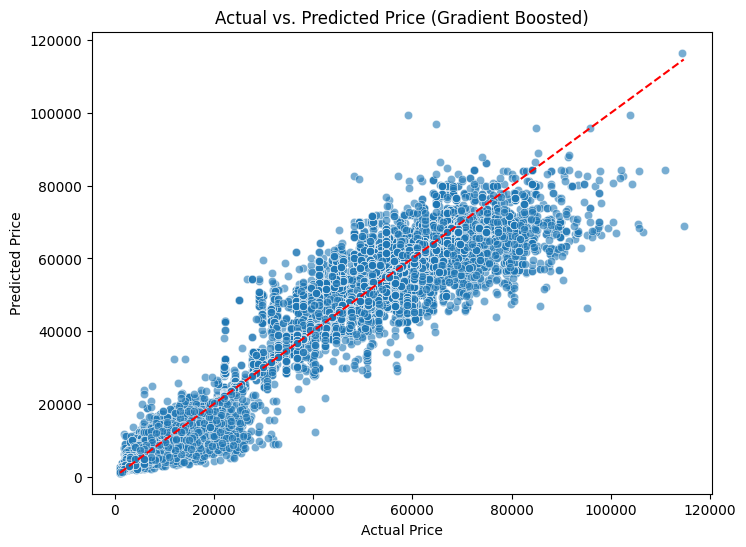

In [ ]:
# Convert Predictions to Pandas DataFrame
y_predictions_pd_gbt = y_predictions_gbt.select("label", "prediction").toPandas()

# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_predictions_pd_gbt['label'], y=y_predictions_pd_gbt['prediction'], alpha=0.6)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price (Gradient Boosted)")
plt.plot([min(y_predictions_pd_gbt['label']), max(y_predictions_pd_gbt['label'])],
         [min(y_predictions_pd_gbt['label']), max(y_predictions_pd_gbt['label'])], color='red', linestyle='--')  # Diagonal line
plt.show()